In [1]:
import os
import os.path as op
from mne import io
import mne
import numpy as np
import torch
from functools import partial
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt

In [2]:
raw_path = r'\\memo-15\DataE\MEGA\raw'

night = 'Night2'
s = 'S02'

In [3]:

data_path_folder = op.join(raw_path, rf'{s}\{night}')
wm = os.listdir(data_path_folder)[-1]
print(wm)
data_path = op.join(raw_path, rf'{s}\{night}\{wm}')

02_Sleep_20170609_05.ds


In [4]:
raw = io.read_raw_ctf(data_path, preload=True)
raw.pick_types(meg=True, stim=True, eeg=True, ref_meg=True)

ds directory : \\memo-15\DataE\MEGA\raw\S02\Night2\02_Sleep_20170609_05.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       2.93   78.28    0.00 mm <->    2.93   78.28   -0.00 mm (orig :  -52.59   54.61 -290.29 mm) diff =    0.000 mm
      -2.93  -78.28    0.00 mm <->   -2.93  -78.28   -0.00 mm (orig :   55.87  -58.44 -291.61 mm) diff =    0.000 mm
     101.90    0.00    0.00 mm <->  101.90   -0.00    0.00 mm (orig :   69.44   68.06 -261.11 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
    10 EEG electrode locations assigned to channel info.
    10 EEG locations added to Polhemus data.
    Measurement info composed.
Finding samples for \\memo-15\DataE\MEGA\raw\S02\Night2\02_Sleep_20170609_05.ds\02_Sleep_20170609_05.meg4: 
    System clock channel is available, checking which samples ar

<RawCTF | 02_Sleep_20170609_05.meg4, 308 x 2359368 (2013.3 s), ~5.41 GiB, data loaded>

In [5]:
events = mne.find_events(raw, stim_channel='UDIO001', initial_event=True)
event_ids = {"maint_FACE": 43, "maint_HOUSE": 53}

events[:,2] = events[:,2] - 255
sel = np.where(events[:, 2] <= 255)[0]
events = events[sel, :]
picks = mne.pick_types(raw.info, meg='mag', eeg=True, stim=False,
                        exclude='bads')
epochs = mne.Epochs(raw, events, event_ids,  picks=picks,tmin=-.2, tmax=4,\
                    baseline=None, preload=True)

2166 events found on stim channel UDIO001
Event IDs: [  256   257   258   259   260   261   264   265   266   268   287   288
   289   291   292   293   295   296   297   298   299   300   301   302
   303   306   307   308   309   310   311   312   313  1280  1320  1328
  1329  1330  1338  1339  2304  4352  4392  4400  4401  4402  4410  4411
 16640 16680 16688 16689 16690 16698 16699 17156]
Not setting metadata
400 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 400 events and 4923 original time points ...
0 bad epochs dropped


In [6]:
epochs.resample(120)
def scale_clamp(
    X: np.ndarray,
    clamp_lim: float = 5.0,
    clamp: bool = True,
) -> np.ndarray:
    X = X.reshape(X.shape[0], -1)
    X = RobustScaler().fit_transform(X)
    if clamp:
        X = X.clip(min=-clamp_lim, max=clamp_lim)
    return X.squeeze()

epochs.apply_function(partial(scale_clamp, clamp_lim=5.0), n_jobs=8)
meg_data = torch.from_numpy(epochs.get_data(picks='meg')).to(torch.float32)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  96 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done 279 out of 279 | elapsed:    6.1s finished


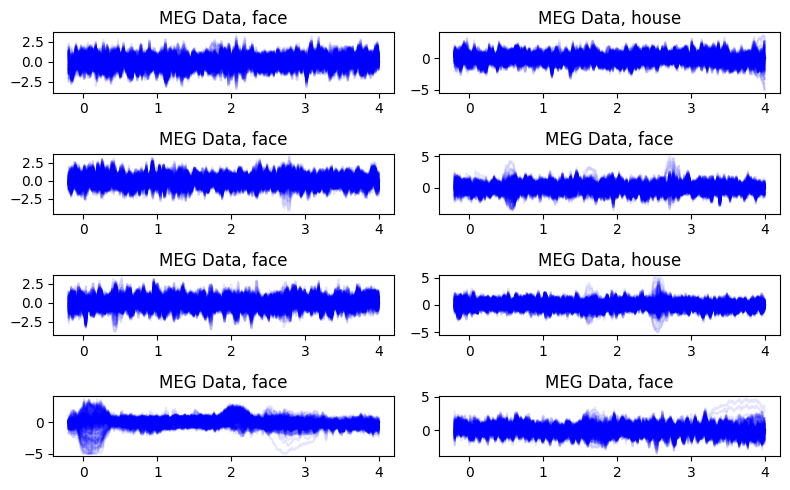

In [7]:
fig, ax = plt.subplots(4, 2, figsize=(8, 5))
for idx, ax in enumerate(ax.flatten()):
    np.random.seed(idx)
    rnd_int = np.random.randint(0, meg_data.shape[0])
    for i in range(meg_data.shape[1]):
        ax.plot(epochs.times, meg_data[rnd_int, i, :].numpy(), color='blue', alpha=0.1)
    ax.set_title(f'MEG Data, {'house' if epochs.events[rnd_int, 2] == 43 else 'face'}')
plt.tight_layout()
plt.show()